# Assignment a04: Neural Networks
A. Thieshanthan, 180641N

In [1]:
import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
import numpy as np 
import matplotlib.pyplot as plt 
import time

In [2]:
def to_tensor(ar):
    ar = tf.convert_to_tensor(ar, dtype=tf.float32)
    return ar

In [3]:
print(
    tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def plot_history(history, title):
    epochs = range(len(history['loss']))
    fig, ax = plt.subplots(1,2, figsize = (20,10))
    ax[0].plot(epochs, history['loss'], label = 'Training Loss')
    ax[0].plot(epochs, history['val_loss'], label = 'Validation Loss')
    ax[0].set_title('Losses')
    ax[0].legend(loc= 'upper center')
    ax[1].plot(epochs, history['accuracy'], label = 'Training Accuracy')
    ax[1].plot(epochs, history['val_accuracy'], label = 'Validation Accuracy')
    ax[1].set_title('Accuracies')
    ax[1].legend(loc= 'lower center')
    plt.savefig('../images/'+ title)
    plt.show()

## 1. Linear Classifier


In [5]:
def get_accuracy(y_hat, y):
  """ Classification accuracy(top one accuracy) """
  y_hat_bin = np.argmax(y_hat,axis=0)
  y_class = np.argmax(y,axis=0)
  return 100*np.sum(y_hat_bin==y_class)/y_class.size

In [6]:
# Loading and Preparing the dataset
(x_train_o, y_train_o), (x_test_o, y_test_o) = cifar10.load_data()
print('x_train shape', x_train_o.shape)
print('y_train shape', y_train_o.shape)

classes = len(np.unique(y_train_o))
training_samples = x_train_o.shape[0]
tesing_samples = x_test_o.shape[0]
input_shape = 32*32*3 # Cifar 10

# Normalizing
x_train_o, x_test_o = x_train_o/255. , x_test_o/255.
mean_image = np.mean(x_train_o, axis = 0)
x_train_o -= mean_image
x_test_o -= mean_image

# one hot encoding
y_train = to_categorical(y_train_o, num_classes=classes).T
y_test = to_categorical(y_test_o, num_classes= classes).T

#reshaping
x_train = np.reshape(x_train_o, (training_samples, input_shape)).T #shape = 3072*50000
x_test = np.reshape(x_test_o, (tesing_samples, input_shape)).T #shape = 3072*10000
print('x_train new shape', x_train.shape)
print('y_train new shape', y_train.shape)
print('x_train_o shape', x_train_o.shape)
print('y_train_o shape', y_train_o.shape)

x_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
x_train new shape (3072, 50000)
y_train new shape (10, 50000)
x_train_o shape (50000, 32, 32, 3)
y_train_o shape (50000, 1)


In [7]:
# converting to tensors
x_train = to_tensor(x_train)
y_train = to_tensor(y_train)
x_test = to_tensor(x_test)
y_test = to_tensor(y_test)

In [12]:
#parameters for linear classifier
std = 1e-3
w1 = to_tensor(np.random.randn(classes, input_shape).astype(np.float32) * std)
b1 = to_tensor(np.zeros((classes, 1)).astype(np.float32))
print('w1 shape: ', w1.shape)
print('b1 shape: ', b1.shape)
batch_size = training_samples
iterations = 300
learning_rate = 0.0015
learning_rate_decay = 0.001 #factor 
reg = 0.01
linear_model_history = {'loss': [], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}
seed = 0
rng = np.random.default_rng(seed=seed)
indices = np.arange(training_samples)

w1 shape:  (10, 3072)
b1 shape:  (10, 1)


In [13]:
# Training
t0 = time.time()
for t in range(iterations):
    # shuffled_x = x_train
    # shuffled_y = y_train
    
    if(t % 60  == 0):
       
        rng.shuffle(indices)
        shuffled_x = x_train.numpy().T[indices]
        shuffled_y = y_train.numpy().T[indices]

        shuffled_x = to_tensor(shuffled_x.T)
        shuffled_y = to_tensor(shuffled_y.T)
    
    # forward pass
    y_hat = tf.matmul(w1, shuffled_x) + b1
    #mean squared error loss
    loss = (tf.math.reduce_sum((shuffled_y - y_hat)**2).numpy() / batch_size) + reg*np.sum(w1*w1)
    loss = float(np.squeeze(loss))
    linear_model_history['loss'].append(loss)
    accuracy = get_accuracy(y_hat, shuffled_y)
    linear_model_history['accuracy'].append(accuracy)
    
    # backward pass
    dw1 = tf.matmul(y_hat - shuffled_y, shuffled_x, transpose_b=True) * (2/batch_size)
    I = tf.ones((batch_size, 1))
    db1 = tf.matmul(y_hat - shuffled_y, I) * (2/batch_size)
    
    # gradient descent
    w1 = w1 - learning_rate * dw1 - (reg * w1)
    b1 = b1 - learning_rate * db1

    # testing
    y_hat_test = tf.matmul(w1, x_test) + b1
    loss_test = (tf.math.reduce_sum((y_test - y_hat_test)**2).numpy() / x_test.shape[1]) + reg*np.sum(w1*w1)
    loss_test = np.squeeze(loss_test)
    linear_model_history['val_loss'].append(loss_test)
    test_acc = get_accuracy(y_hat_test, y_test)
    linear_model_history['val_accuracy'].append(test_acc)

    
    if t % 100 == 0:
        print('epoch: '+ str(t + 1))
        print('loss: %.4f' % (linear_model_history['loss'][-1]), end = '     ')
        print('accuracy: %.4f' % linear_model_history['accuracy'][-1], end='    ')
        print('Test loss: %.4f' % (linear_model_history['val_loss'][-1]), end = '   ')
        print('Test accuracy: %.4f' % linear_model_history['val_accuracy'][-1])
        # reducing learning rate
        learning_rate = learning_rate * (1-learning_rate_decay)

print('epoch: '+ str(t + 1))
print('loss: %.4f' % (linear_model_history['loss'][-1]), end = '     ')
print('accuracy: %.4f' % linear_model_history['accuracy'][-1], end='    ')
print('Test loss: %.4f' % (linear_model_history['val_loss'][-1]), end = '   ')
print('Test accuracy: %.4f' % linear_model_history['val_accuracy'][-1])
t1 = time.time()
print('End of Training. time taken: %.2f seconds'  % (t1-t0))

epoch: 1
loss: 1.0081     accuracy: 7.1940    Test loss: 0.9988   Test accuracy: 11.5500
epoch: 101
loss: 0.8840     accuracy: 34.0660    Test loss: 0.8830   Test accuracy: 34.3600
epoch: 201
loss: 0.8557     accuracy: 35.1380    Test loss: 0.8550   Test accuracy: 35.0100
epoch: 300
loss: 0.8415     accuracy: 35.3540    Test loss: 0.8410   Test accuracy: 35.2500
End of Training. time taken: 37.45 seconds


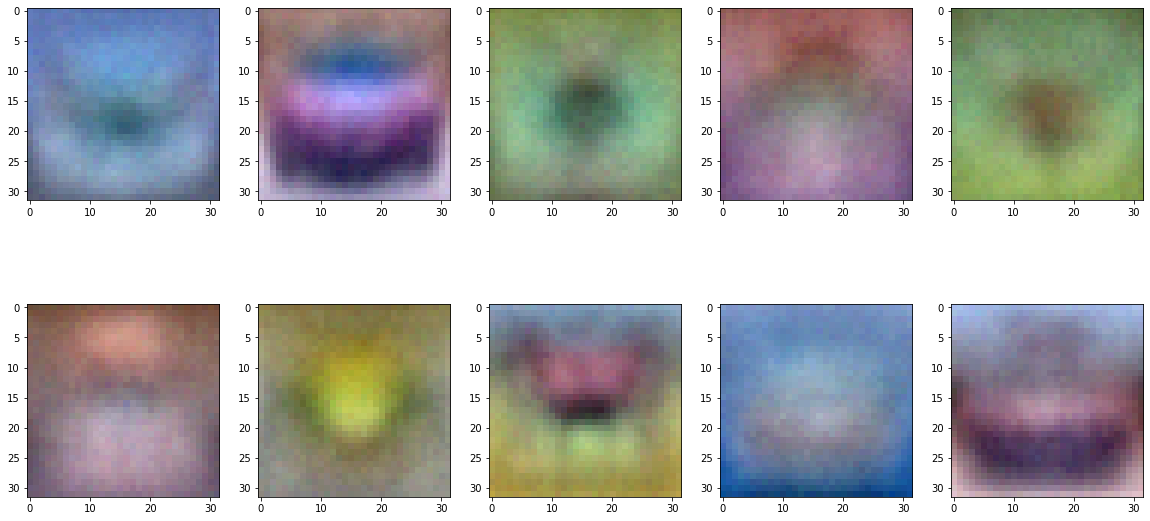

In [14]:
# Displaying W as 10 images
w_image = w1.numpy().T
# print(w_image.shape)
# w_image = np.reshape(w_image, (32,32,3,10))
w_image -= w_image.min()
w_image = (w_image /np.amax(w_image)).astype(np.float32)
fig, ax = plt.subplots(2,5, figsize = (20,10))
for i in range(10):
    im = w_image[:,i]
    im = np.reshape(im, (32,32,3))
    ax[i//5, i%5].imshow(im, cmap = 'gray')
plt.savefig('../images/weights')    
plt.show()

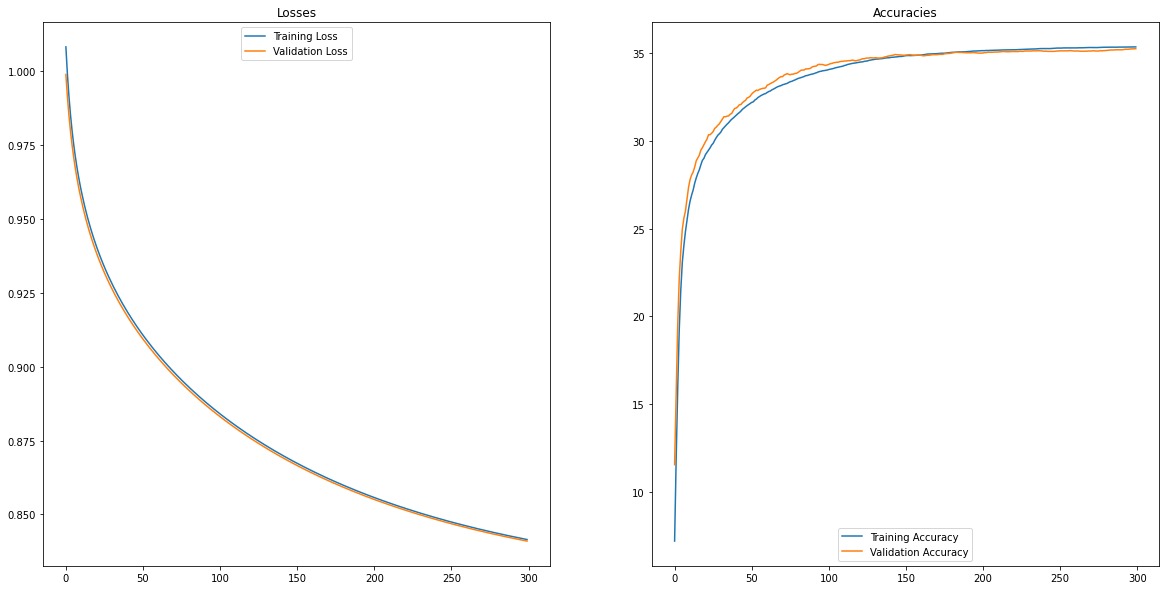

In [15]:
plot_history(linear_model_history, 'linear_model')

## 2. Two layer fully connected network
### Specifications
    * 200 hidden units
    * Sigmoid activation for hidden layer
    * No output layer activation

In [19]:
def sigmoid(z):
    return 1 / (1 + tf.math.exp(-z))

In [24]:
# Parameters
H = 200
std = 1e-2
w1 = to_tensor(np.random.randn(H, input_shape).astype(np.float32) * std)
b1 = to_tensor(np.zeros((H, 1)))
w2 = to_tensor(np.random.randn(classes, H).astype(np.float32) * std)
b2 = to_tensor(np.zeros((classes, 1)))
print('w1 shape: ', w1.shape)
print('b1 shape: ', b1.shape)
print('w2 shape: ', w2.shape)
print('b2 shape: ', b2.shape)

batch_size_2 = training_samples
iterations_2 = 300
learning_rate_2 = 0.015
learning_rate_decay_2 = 0.005
reg_2 = 0
two_layer_nn_history = {'loss': [], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}
seed = 0
rng = np.random.default_rng(seed=seed)
indices = np.arange(training_samples)

w1 shape:  (200, 3072)
b1 shape:  (200, 1)
w2 shape:  (10, 200)
b2 shape:  (10, 1)


In [25]:
# Training
t0 = time.time()
for t in range(iterations_2):
    # shuffled_x = x_train
    # shuffled_y = y_train
    if(t % 60  == 0):
        rng.shuffle(indices)
        shuffled_x = x_train.numpy().T[indices]
        shuffled_y = y_train.numpy().T[indices]

        shuffled_x = to_tensor(shuffled_x.T)
        shuffled_y = to_tensor(shuffled_y.T)

    #forward pass
    z1 = tf.matmul(w1, shuffled_x) + b1
    a1 = sigmoid(z1)
    z2 = tf.matmul(w2, a1) + b2
    y_hat = z2 #no activation
    #mean squared error loss
    loss = tf.math.reduce_sum((shuffled_y - y_hat)**2).numpy() / batch_size
    loss = float(np.squeeze(loss))
    two_layer_nn_history['loss'].append(loss)
    accuracy = get_accuracy(y_hat, shuffled_y)
    two_layer_nn_history['accuracy'].append(accuracy)
    # backward pass
    dz2 = (2/batch_size) * (y_hat - shuffled_y)
    dw2 = tf.matmul(dz2, a1, transpose_b= True)
    db2 = np.sum(dz2.numpy(), axis = 1, keepdims=True)
    da1 = tf.matmul(w2, dz2, transpose_a=True)
    dz1 = da1 * a1*(1-a1)
    dw1 = tf.matmul(dz1, shuffled_x, transpose_b= True)
    db1 = np.sum(dz1.numpy(), axis = 1, keepdims=True)

    # dz2 =  (y_hat-y_train)
    # dw2 = (2/batch_size) * tf.matmul(dz2, a1, transpose_b= True) 
    # db2 = (2/batch_size) * np.sum(dz2.numpy(), axis = 1, keepdims=True)
    # da1 = tf.matmul(w2, dz2, transpose_a=True)
    # dz1 = da1 * a1*(1-a1)
    # dw1 = (2/batch_size) *tf.matmul(dz1, x_train, transpose_b= True)
    # db1 = (2/batch_size) *np.sum(dz1.numpy(), axis = 1, keepdims=True)
    # gradient descent
    w2 = w2 - learning_rate_2 * dw2 
    b2 = b2 - learning_rate_2 * db2
    w1 = w1 - learning_rate_2 * dw1
    b1 = b1 - learning_rate_2 * db1
    
    #testing
    z1t = tf.matmul(w1, x_test) + b1
    a1t = sigmoid(z1t)
    z2t = tf.matmul(w2, a1t) + b2
    y_hat_test = z2t #no activation
    #mean squared error loss
    loss_test = tf.math.reduce_sum((y_test - y_hat_test)**2).numpy() / x_test.shape[1]
    loss_test = float(np.squeeze(loss_test))
    two_layer_nn_history['val_loss'].append(loss_test)
    accuracy_t = get_accuracy(y_hat_test, y_test)
    two_layer_nn_history['val_accuracy'].append(accuracy_t)

    if t % 50 == 0:
        print('epoch: '+ str(t + 1))
        print('loss: %.4f' % (two_layer_nn_history['loss'][-1]), end = '     ')
        print('accuracy: %.4f' % two_layer_nn_history['accuracy'][-1], end='    ')
        print('Test loss: %.4f' % (two_layer_nn_history['val_loss'][-1]), end = '   ')
        print('Test accuracy: %.4f' % two_layer_nn_history['val_accuracy'][-1])
        #learning rate ruduction
        learning_rate_2 = learning_rate_2 * (1 - learning_rate_decay_2)

print('epoch: '+ str(t + 1))
print('loss: %.4f' % (two_layer_nn_history['loss'][-1]), end = '     ')
print('accuracy: %.4f' % two_layer_nn_history['accuracy'][-1], end='    ')
print('Test loss: %.4f' % (two_layer_nn_history['val_loss'][-1]), end = '   ')
print('Test accuracy: %.4f' % two_layer_nn_history['val_accuracy'][-1])
t1 = time.time()
print('End of Training. time taken: %.2f seconds'  % (t1-t0))

epoch: 1
loss: 1.0382     accuracy: 10.0000    Test loss: 0.9389   Test accuracy: 11.0000
epoch: 51
loss: 0.8914     accuracy: 24.4400    Test loss: 0.8910   Test accuracy: 24.5100
epoch: 101
loss: 0.8829     accuracy: 25.5900    Test loss: 0.8824   Test accuracy: 26.0600
epoch: 151
loss: 0.8747     accuracy: 26.2960    Test loss: 0.8740   Test accuracy: 26.4400
epoch: 201
loss: 0.8675     accuracy: 26.6020    Test loss: 0.8667   Test accuracy: 27.0800
epoch: 251
loss: 0.8615     accuracy: 26.9220    Test loss: 0.8606   Test accuracy: 27.4800
epoch: 300
loss: 0.8566     accuracy: 27.3600    Test loss: 0.8557   Test accuracy: 27.8900
End of Training. time taken: 70.77 seconds


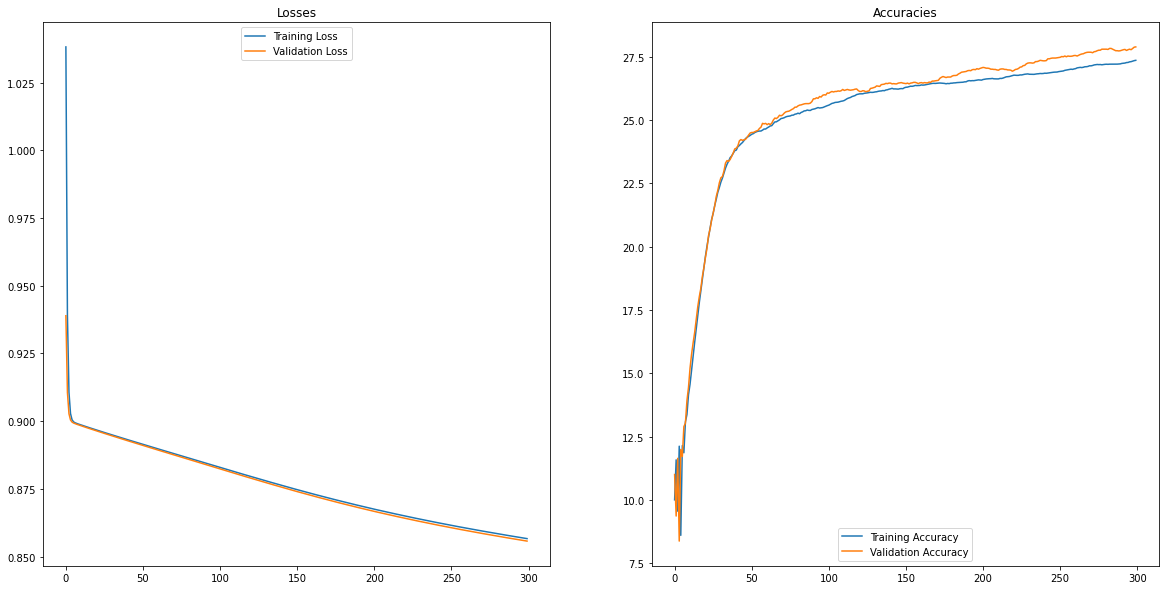

In [26]:
plot_history(two_layer_nn_history,  'two_layer_nn')

## 3. Stochastic Gradient Descent

In [27]:
# Parameters for 2 layer with SGD
H = 200
std = 1e-2
w1 = to_tensor(np.random.randn(H, input_shape).astype(np.float32) * std)
b1 = to_tensor(np.zeros((H, 1)))
w2 = to_tensor(np.random.randn(classes, H).astype(np.float32) * std)
b2 = to_tensor(np.zeros((classes, 1)))
print('w1 shape: ', w1.shape)
print('b1 shape: ', b1.shape)
print('w2 shape: ', w2.shape)
print('b2 shape: ', b2.shape)

batch_size = 500
steps = int(training_samples / batch_size)
iterations = 200
learning_rate = 0.015
learning_rate_decay = 0.005
reg = 0
two_layer_nn_sgd_history = {'loss': [], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}
seed = 0
rng = np.random.default_rng(seed=seed)

w1 shape:  (200, 3072)
b1 shape:  (200, 1)
w2 shape:  (10, 200)
b2 shape:  (10, 1)


In [28]:
# Training
t0 = time.time()
for t in range(iterations):
    if(t % 60  == 0):
        rng.shuffle(indices)
        shuffled_x = x_train.numpy().T[indices]
        shuffled_y = y_train.numpy().T[indices]

        # shuffled_x = to_tensor(shuffled_x.T)
        # shuffled_y = to_tensor(shuffled_y.T)
    for s in range(steps):
        x_mini = to_tensor(shuffled_x[batch_size*s:batch_size*(s+1) - 1].T)
        y_mini = to_tensor(shuffled_y[batch_size*s:batch_size*(s+1) - 1].T)

        # Forward pass
        z1 = tf.matmul(w1, x_mini) + b1
        a1 = sigmoid(z1)
        z2 = tf.matmul(w2, a1) + b2
        y_hat = z2

        # loss
        loss = tf.math.reduce_sum((y_mini - y_hat)**2).numpy() / batch_size
        loss = float(np.squeeze(loss))
        
        # accuracy
        accuracy = get_accuracy(y_hat, y_mini)
        

        # backward pass
        dz2 = (2/batch_size) * (y_hat-y_mini)
        dw2 = tf.matmul(dz2, a1, transpose_b= True)
        db2 = np.sum(dz2.numpy(), axis = 1, keepdims=True)
        da1 = tf.matmul(w2, dz2, transpose_a=True)
        dz1 = da1 * a1*(1-a1)
        dw1 = tf.matmul(dz1, x_mini, transpose_b= True)
        db1 = np.sum(dz1.numpy(), axis = 1, keepdims=True)

        # gradient descent
        w2 = w2 - learning_rate_2 * dw2 
        b2 = b2 - learning_rate_2 * db2
        w1 = w1 - learning_rate_2 * dw1
        b1 = b1 - learning_rate_2 * db1

    # saving training loss and accuracy after minibatch completion
    two_layer_nn_sgd_history['loss'].append(loss)
    two_layer_nn_sgd_history['accuracy'].append(accuracy)

    # testing
    z1t = tf.matmul(w1, x_test) + b1
    a1t = sigmoid(z1t)
    z2t = tf.matmul(w2, a1t) + b2
    y_hat_test = z2t #no activation
    # mean squared error loss
    loss_test = tf.math.reduce_sum((y_test - y_hat_test)**2).numpy() / x_test.shape[1]
    loss_test = float(np.squeeze(loss_test))
    two_layer_nn_sgd_history['val_loss'].append(loss_test)
    accuracy_t = get_accuracy(y_hat_test, y_test)
    two_layer_nn_sgd_history['val_accuracy'].append(accuracy_t)

    if t % 10 == 0:
        print('epoch: '+ str(t + 1))
        print('loss: %.4f' % (two_layer_nn_sgd_history['loss'][-1]), end = '     ')
        print('accuracy: %.4f' % two_layer_nn_sgd_history['accuracy'][-1], end='    ')
        print('Test loss: %.4f' % (two_layer_nn_sgd_history['val_loss'][-1]), end = '   ')
        print('Test accuracy: %.4f' % two_layer_nn_sgd_history['val_accuracy'][-1])
        #learning rate ruduction
        learning_rate = learning_rate * (1 - learning_rate_decay)

print('epoch: '+ str(t + 1))
print('loss: %.4f' % (two_layer_nn_sgd_history['loss'][-1]), end = '     ')
print('accuracy: %.4f' % two_layer_nn_sgd_history['accuracy'][-1], end='    ')
print('Test loss: %.4f' % (two_layer_nn_sgd_history['val_loss'][-1]), end = '   ')
print('Test accuracy: %.4f' % two_layer_nn_sgd_history['val_accuracy'][-1])
t1 = time.time()
print('End of Training. time taken: %.2f seconds'  % (t1-t0))

epoch: 1
loss: 0.8902     accuracy: 13.2265    Test loss: 0.8930   Test accuracy: 12.1600
epoch: 11
loss: 0.8333     accuracy: 29.4589    Test loss: 0.8336   Test accuracy: 30.4900
epoch: 21
loss: 0.8207     accuracy: 33.0661    Test loss: 0.8200   Test accuracy: 34.0000
epoch: 31
loss: 0.8132     accuracy: 35.4709    Test loss: 0.8118   Test accuracy: 36.0400
epoch: 41
loss: 0.8080     accuracy: 36.4729    Test loss: 0.8069   Test accuracy: 37.0300
epoch: 51
loss: 0.8041     accuracy: 37.6754    Test loss: 0.8036   Test accuracy: 37.6400
epoch: 61
loss: 0.8032     accuracy: 34.2685    Test loss: 0.7981   Test accuracy: 38.6100
epoch: 71
loss: 0.8015     accuracy: 34.2685    Test loss: 0.7964   Test accuracy: 38.9700
epoch: 81
loss: 0.8000     accuracy: 34.8697    Test loss: 0.7950   Test accuracy: 39.2700
epoch: 91
loss: 0.7984     accuracy: 35.0701    Test loss: 0.7938   Test accuracy: 39.5800
epoch: 101
loss: 0.7969     accuracy: 35.6713    Test loss: 0.7927   Test accuracy: 39.7200

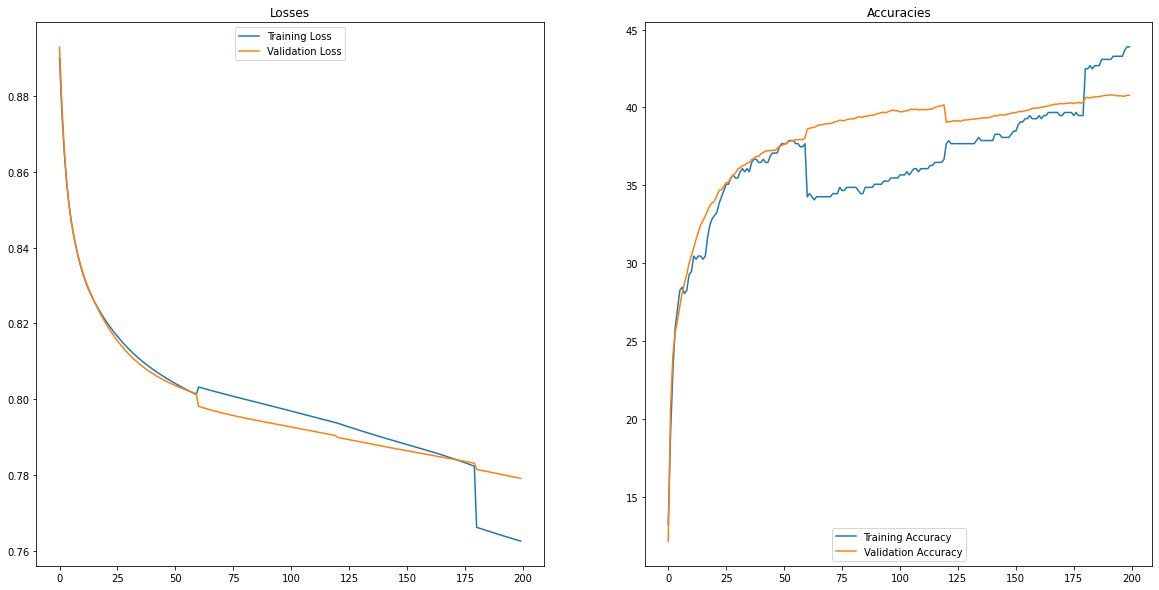

In [29]:
plot_history(two_layer_nn_sgd_history,  'two_layer_nn_sgd')

## 4. Convolutional Neural Network

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy

In [31]:
model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), input_shape = (32,32,3), activation='relu'),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(filters = 64, kernel_size = (3,3), activation='relu'),
    MaxPooling2D(pool_size = (2,2)),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(10, activation = 'softmax')
])

In [32]:
optimizer = SGD(learning_rate = 0.01, momentum=0.1, )
model.compile(optimizer= optimizer, loss= categorical_crossentropy, metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [34]:
y_train = y_train.numpy().T 
y_test = y_test.numpy().T

In [35]:
# printing shapes
print(x_train_o.shape)
print(y_train.shape)
print(x_test_o.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [38]:
epochs =  50

In [39]:
training_history = model.fit(x = x_train_o, y= y_train,epochs=epochs, batch_size=50, validation_data=(x_test_o, y_test), verbose = 2)

Epoch 1/50
1000/1000 - 6s - loss: 2.1508 - accuracy: 0.2216 - val_loss: 1.9252 - val_accuracy: 0.3019
Epoch 2/50
1000/1000 - 5s - loss: 1.8038 - accuracy: 0.3401 - val_loss: 1.6609 - val_accuracy: 0.3937
Epoch 3/50
1000/1000 - 5s - loss: 1.6016 - accuracy: 0.4148 - val_loss: 1.5172 - val_accuracy: 0.4491
Epoch 4/50
1000/1000 - 5s - loss: 1.4825 - accuracy: 0.4608 - val_loss: 1.4308 - val_accuracy: 0.4826
Epoch 5/50
1000/1000 - 5s - loss: 1.3940 - accuracy: 0.4985 - val_loss: 1.3703 - val_accuracy: 0.5080
Epoch 6/50
1000/1000 - 5s - loss: 1.3228 - accuracy: 0.5264 - val_loss: 1.2987 - val_accuracy: 0.5345
Epoch 7/50
1000/1000 - 5s - loss: 1.2613 - accuracy: 0.5520 - val_loss: 1.2595 - val_accuracy: 0.5540
Epoch 8/50
1000/1000 - 5s - loss: 1.2092 - accuracy: 0.5711 - val_loss: 1.1990 - val_accuracy: 0.5702
Epoch 9/50
1000/1000 - 5s - loss: 1.1622 - accuracy: 0.5916 - val_loss: 1.1511 - val_accuracy: 0.5933
Epoch 10/50
1000/1000 - 6s - loss: 1.1183 - accuracy: 0.6083 - val_loss: 1.1462 - 

In [40]:
print(training_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


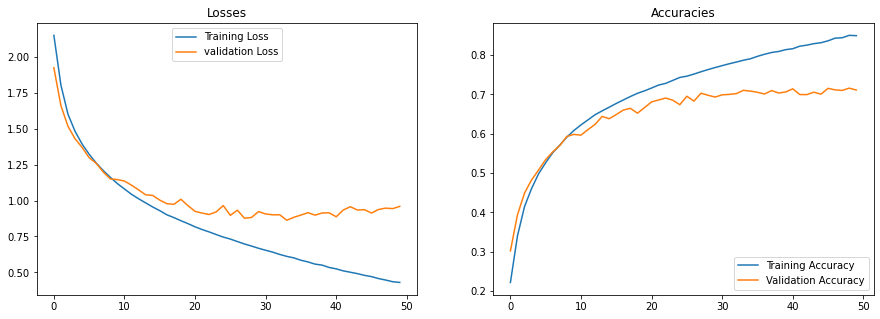

In [41]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(range(epochs), training_history.history['loss'], label = 'Training Loss')
ax[0].plot(range(epochs), training_history.history['val_loss'], label= 'validation Loss')
ax[0].legend(loc ='upper center')
ax[0].set_title('Losses')
ax[1].plot(range(epochs), training_history.history['accuracy'], label = 'Training Accuracy')
ax[1].plot(range(epochs), training_history.history['val_accuracy'], label = 'Validation Accuracy')
ax[1].legend(loc='lower right')
ax[1].set_title('Accuracies')
plt.savefig('../images/cnn_model')
plt.show()